#### Overview

Laplace's method in sampling utilizes Taylor approximation of distribution $f(x)$

For example, we consider the following expression:

$$f(x) = \exp(-x^{1.5})(2 + \sin(3x) + \sin(4x)), \quad \text{for } x \in [0, 3]$$

While $f(x)$ itself is not a distribution, we can certainly make it so by `dividing it with the area underneath` $f(x)$ in [0, 3], which `normalizes` the $f(x)$, and we call the area the `normalizing factor` of $f(x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm
plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [2]:
# Unnormalized distribution
def target_pdf(x):
    return np.exp(-x**1.5) * (2 + np.sin(3 * x) + np.sin(4 * x))

# Compute normalizing factor using numerical integration
normalizing_factor, _ = quad(target_pdf, 0, 3)

# Normalized distribution
def normalized_pdf(x):
    return target_pdf(x) / normalizing_factor

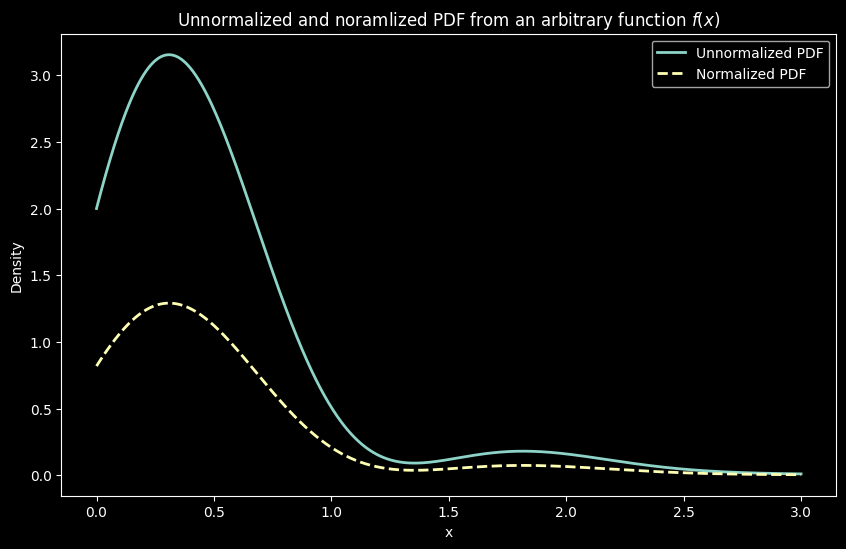

In [3]:
x = np.linspace(0, 3, 1000)
y_unnormalized = target_pdf(x)
y_normalized = normalized_pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y_unnormalized, label='Unnormalized PDF', linewidth=2)
plt.plot(x, y_normalized, label='Normalized PDF', linewidth=2, linestyle='--')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Unnormalized and noramlized PDF from an arbitrary function $f(x)$')
plt.show()

#### Laplace's method for sampling

Laplace's method uses up to the `second-derivative` term of `Taylor` approximation of $f(x)$

For convenience, Taylor approximation is done on $\log f(x)$ at some fixed point $x_0$ to describe the behavior of $f(x)$ around $x_0$ as

$$\boxed{\log f(x)\approx \log f(x_0) + \color{red}{\frac{d}{dx}\log f(x_0)\cdot (x-x_0)} + \color{orange}{\frac{1}{2}\frac{d^2}{dx^2}\log f(x_0)\cdot (x-x_0)^2}+ .... }$$

Very often, we choose $x_0$ as the `maximizer` of $f(x)$ to make the `first-derivative` term go away. In our case, $x_0\approx 0.3$

In practical application, this $x_0$ is commonly obtained using optimization such as gradient descent. Both maximum-likelihood (ML) estimator and maximum-a-posteriori (MAP) estimator are commonly used as $x_0$

By choosing $x_0$, we then take the exponential on both side of the equation to `recover` $f(x)$ as

$$f(x)\approx f(x_0)\cdot \color{orange}{e^{-\frac{1}{2}\frac{(x-x_0)^2}{\left(-\frac{d^2}{dx^2}\log f(x_0)\right)^{-1}}}}$$

We see that this is indeed an `unnormalized` Gaussian distribution with `mean` at $x_0$ and `standard deviation` of $\sqrt{\left(-\frac{d^2}{dx^2}\log f(x_0)\right)^{-1}}$

By using the mean and standard deviation, NumPy will automatically take care of the constant factor in Gaussian distribution

Second derivative of a function can be computed using `finite difference` approach, to avoid derivation of explicit expression

$$f^{"}(a)\approx \frac{\frac{f(a+h)-f(a)}{h}-\frac{f(a)-f(a-h)}{h}}{h}=\frac{f(a+h)-2f(a)+f(a-h)}{h^2}$$

where $h$ is a very small value, and $f(x)$ can be replaced by other functions, such as $\log f(x)$ in our case

In [4]:
# log of f(x)
def log_target_pdf(x):
    return -x**1.5 + np.log(2 + np.sin(3 * x) + np.sin(4 * x))

x_0=0.3

# Compute second derivative of logf(x) at x_0 using finite difference
h = 1e-5
second_derivative = (log_target_pdf(x_0 + h) - 2 * log_target_pdf(x_0) + log_target_pdf(x_0 - h)) / h**2
variance = (-second_derivative)**-1
std_dev = np.sqrt(variance)

# Sample points from Gaussian approximation
n_samples = 10000
gaussian_samples = np.random.normal(loc=x_0, scale=std_dev, size=n_samples)

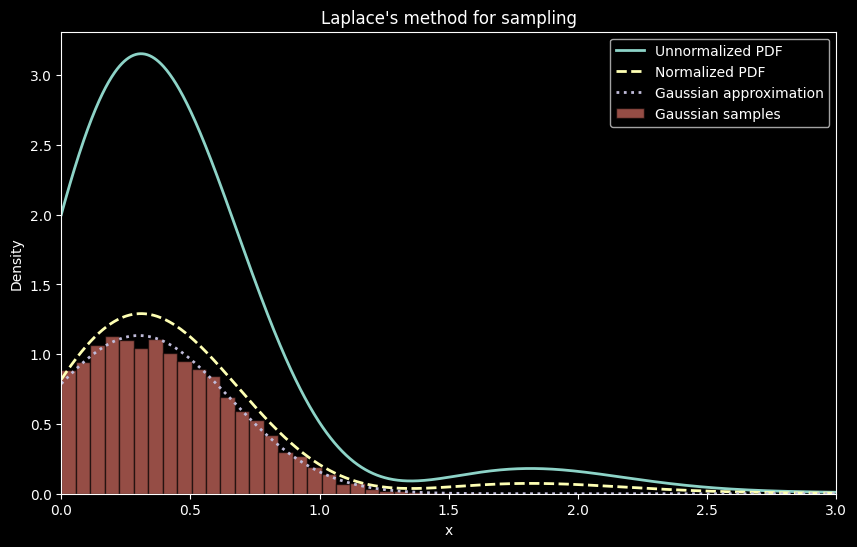

In [5]:
# Gaussian that approximates f(x) using Laplace method
def gaussian_approx(x):
    return norm.pdf(x, loc=x_0, scale=std_dev)

x = np.linspace(0, 3, 1000)
y_unnormalized = target_pdf(x)
y_normalized = normalized_pdf(x)
y_gaussian = gaussian_approx(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y_unnormalized, label='Unnormalized PDF', linewidth=2)
plt.plot(x, y_normalized, label='Normalized PDF', linewidth=2, linestyle='--')
plt.plot(x, y_gaussian, label='Gaussian approximation', linewidth=2, linestyle=':')
plt.hist(gaussian_samples, bins=50, density=True, alpha=0.6, label='Gaussian samples', edgecolor='black')
plt.xlabel('x')
plt.xlim(0, 3)
plt.ylabel('Density')
plt.legend()
plt.title("Laplace's method for sampling")
plt.show()

We can see, the samples taken follows the distribution of the Gaussian approximation of the normalized $f(x)$, rather than normalized $f(x)$ itself.


As a result, the method heavily relies on the behavior of $f(x)$ around $x_0$ to resemble Gaussian distribution to work well